In [1]:
#  imported the essential libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# read the file 
lcl_df = pd.read_csv("operational_excellence on_time_execution 2025-04-16T2128.csv")
pd.set_option('display.max_columns', None)
lcl_df.head()

,Shipments: Client Client ID,Shipments: Attributes Ocean type category,Shipments: Attributes Ocean LCL subcategory,Shipments: Attributes Shipment ID,Shipments: Locations Departure port Ocean LOC,Shipments: Locations Final port Ocean LOC,Shipment Containers: Actual Timeline (local) Departure Port Departed On Date,Shipments: Attributes Tradelane,On Time Performance OTP Promised Delivery Week,On Time Performance OTP Promised Delivery Date,Shipment Containers: Actual Timeline (local) In Full Delivered On Date,On Time Performance Primary Delay Stage,Transit Time: Quote Quoted Origin Total Days,On Time Performance Quoted Port to Port Days,On Time Performance Quoted Destination Total Days,On Time Performance Actual Origin Total Days,On Time Performance Actual Port to Port Days,On Time Performance Actual Destination Total Days,Shipments: Attributes CO2 Emissions (Tonnes),Shipments: Attributes Gross Weight (kg),Shipments: Attributes Volume (cbm),Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Involved Parties Destination Agent Company Name,Shipments: Involved Parties Origin Agent Company Name,Shipments: Involved Parties To Destination Carrier Name,Shipments: Locations Destination Coordinates,Shipments: Locations Origin Coordinates,Shipments: Attributes Freight Type,Shipments: Locations Arrival port Coordinates,Shipments: Locations Departure port Coordinates,On Time Performance Origin on Time Performance,On Time Performance Port to Port on Time Performance,On Time Performance Destination on Time Performance,On Time Performance On Time Performance,Port pair,Total Quoted Days,Total Actual Days,Delta quoted vs actual total days,Delta actual vs quoted origin days,Delta actual vs quoted p2p days,Delta actual vs quoted destination days
0,76528,coloaded_lcl,Shipco Transport,3051512,DEHAM,USATL,2025-03-11,TAWB,2025-04-07,2025-04-08,2025-04-14,Origin_Terminal,13.0,38.0,4.0,27.0,30.7,12.5,0.07,323,2.622,160.13,358.66,Flexport,Flexport Carrier Booking Operations,Special Service Freight Company,"34.8524089,-82.1421987","50.8720702,6.9040396",Port to Door,"32.7764749,-79.93105120000001","53.5510846,9.9936819",0.0%,100.0%,100.0%,0.0%,DEHAM - USATL,55,70.0,15.0,14.0,-7.0,8.0
1,11690,coloaded_lcl,ECU Worldwide,3065451,DEHAM,USCHI,2025-03-14,TAWB,2025-04-07,2025-04-10,2025-04-07,On Time,15.0,25.0,5.0,18.0,21.3,5.5,0.09,490,0.538,30.83,346.84,Flexport,Flexport Carrier Booking Operations,"Pronto Freightways, Inc.","41.8554967,-87.8144195","50.8163314,7.368568199999999",Door to Door,"45.5016889,-73.567256","53.5510846,9.9936819",0.0%,100.0%,100.0%,100.0%,DEHAM - USCHI,45,45.0,0.0,3.0,-4.0,0.0
2,74791,coloaded_lcl,Shipco Transport,3022941,BDCGP,USLAX,2025-01-29,TPEB,2025-04-07,2025-04-10,2025-03-19,On Time,13.0,58.0,2.0,2.6,48.5,6.2,0.40,"1,913",11.360,54.37,233.94,Flexport,Dart Global Logistics (PVT) - Bangladesh,"ARC Logistics, Inc.","34.0281946,-117.3784815","23.9304077,90.2643401",Port to Door,"34.0522342,-118.2436849","22.356851,91.7831819",100.0%,100.0%,100.0%,100.0%,BDCGP - USLAX,73,57.0,-16.0,-10.0,-9.0,4.0
3,83962,coloaded_lcl,Shipco Transport,3024506,INNSA,GBFXT,2025-02-01,FEWB,2025-04-07,2025-04-08,2025-03-19,On Time,15.0,56.0,4.0,9.5,41.2,6.6,0.26,752,0.508,147.02,421.03,Flexport Carrier Booking Operations,Contech Logistics Solutions Pvt. Ltd.,Lombard,"51.9165818,-2.0997262","22.1572507,70.7990772",Door to Door,"51.961726,1.351255","18.9499361,72.9511875",100.0%,100.0%,0.0%,100.0%,INNSA - GBFXT,75,57.0,-18.0,-5.0,-15.0,3.0
4,46128,flxt_lcl,flxt_lcl_child,3055002,TWKHH,USLAX,2025-02-23,TPEB,2025-04-07,2025-04-09,2025-03-25,On Time,13.0,35.0,9.0,12.4,17.5,13.1,4.38,"6,471",8.110,"1,793.56",296.68,Flexport,"PGS (Taiwan) Logistics Co., Ltd",Flock Freight Inc,"41.6924245,-86.80212759999999","25.0169826,121.4627868",Port to Door,"34.0522342,-118.2436849","22.6272784,120.3014353",100.0%,100.0%,0.0%,100.0%,TWKHH - USLAX,57,43.0,-14.0,-1.0,-18.0,4.0


In [3]:
# list of columns which are not a predictor 
INITIAL_DROP_COLS = [
    'Shipments: Client Client ID',
    'Shipments: Attributes Ocean LCL subcategory',
    'Shipments: Locations Destination Coordinates',
    'Shipments: Locations Origin Coordinates',
    'Shipments: Locations Departure port Ocean LOC',
    'Total Quoted Days',
    'Shipments: Locations Final port Ocean LOC',
    'Shipment Containers: Actual Timeline (local) Departure Port Departed On Date',
    'On Time Performance OTP Promised Delivery Week',
    'On Time Performance OTP Promised Delivery Date',
    'Shipment Containers: Actual Timeline (local) In Full Delivered On Date',
    'Transit Time: Quote Quoted Origin Total Days',
    'On Time Performance Quoted Port to Port Days',
    'On Time Performance Quoted Destination Total Days',
    'On Time Performance Actual Origin Total Days',
    'On Time Performance Actual Port to Port Days',
    'On Time Performance Actual Destination Total Days',
    'On Time Performance Origin on Time Performance',
    'On Time Performance Port to Port on Time Performance',
    'On Time Performance Destination on Time Performance',
    'On Time Performance On Time Performance',
    'Delta quoted vs actual total days',
    'Delta actual vs quoted origin days', 'Delta actual vs quoted p2p days',
    'Delta actual vs quoted destination days',
    'On Time Performance Primary Delay Stage',
    'Shipments: Attributes CO2 Emissions (Tonnes)',
    'Shipments: Involved Parties Destination Agent Company Name',
    'Shipments: Involved Parties Origin Agent Company Name',
    'Shipments: Involved Parties To Destination Carrier Name'
]

# dropping those columns
lcl_df.drop(columns=INITIAL_DROP_COLS, inplace=True)


In [4]:
# spitting the co-ordinates and droping it 
lcl_df[['dest_latitude', 'dest_longitude']] = lcl_df['Shipments: Locations Arrival port Coordinates'] \
    .str.split(',', expand=True).astype(float)
lcl_df[['org_latitude', 'org_longitude']] = lcl_df['Shipments: Locations Departure port Coordinates'] \
    .str.split(',', expand=True).astype(float)
lcl_df = lcl_df.drop(["Shipments: Locations Arrival port Coordinates","Shipments: Locations Departure port Coordinates"], axis=1)


In [5]:
# columns to convert into float data type 
cols_to_convert = [
    'Shipments: Attributes Gross Weight (kg)', 
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km'
]

# Remove commas and convert to float
lcl_df[cols_to_convert] = lcl_df[cols_to_convert].replace(',', '', regex=True).astype(float)


In [6]:
# 1. Feature Engineering fewb tawb TPEB
# Weight-to-volume ratio
lcl_df = lcl_df[lcl_df['Shipments: Attributes Tradelane'] == 'TPEB'].copy()

lcl_df['Weight_to_Volume'] = lcl_df['Shipments: Attributes Gross Weight (kg)'] / (lcl_df['Shipments: Attributes Volume (cbm)'] + 1e-6)

# Total shipment distance (km + converted miles)
lcl_df['Total_Shipment_Distance_km'] = lcl_df['Shipment Containers: Distance Origin to First Port Distance in km'] + (lcl_df['Shipment Containers: Distance Final Port to Destination Distance in mile'] * 1.60934)

# Efficiency calculation
# lcl_df['Efficiency'] = lcl_df['Weight_to_Volume'] / (lcl_df['Total Actual Days'] + 1e-6)

# Split port pair into origin and destination
lcl_df[['Origin Port', 'Destination Port']] = lcl_df['Port pair'].str.split(' - ', expand=True)

# calculating the geo distance from the splitted co-ordinates
lcl_df['Geo Distance'] = lcl_df.apply(
    lambda row: geodesic(
        (row['org_latitude'], row['org_longitude']), 
        (row['dest_latitude'], row['dest_longitude'])
    ).km, axis=1
)

# Speed calculation in a day
# lcl_df['Speed_km_per_day'] = lcl_df['Geo Distance'] / (lcl_df['Total Actual Days'] + 1e-6)

# Droping unused or now redundant columns
lcl_df.drop([
    "Shipments: Attributes Tradelane", "Port pair",
    "Shipments: Attributes Gross Weight (kg)",
    "Shipments: Attributes Volume (cbm)",
], axis=1, inplace=True)

# dropping the non available 
lcl_df = lcl_df.dropna()



In [7]:
# list of numerical columns for outliers removal
numeric_cols = [
    'Shipments: Attributes Shipment ID',
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km',	
    'dest_latitude',	
    'dest_longitude',	
    'org_latitude',	
    'org_longitude',	
    'Weight_to_Volume',	
    'Total_Shipment_Distance_km',		
    'Geo Distance',
    # 'Speed_km_per_day',
    # 'Efficiency'
]
N = lcl_df[numeric_cols]


In [8]:
# outliers removal 
iso_outliers = IsolationForest(contamination=0.02, random_state=42).fit_predict(N)
lof_outliers = LocalOutlierFactor(n_neighbors=20, contamination=0.02).fit_predict(N)

# Keep rows marked as inliers (1) by both methods
df_clean = lcl_df[(iso_outliers == 1) & (lof_outliers == 1)].copy()


In [9]:
# Prepare X and y
X = df_clean.drop("Total Actual Days", axis=1)
y = df_clean["Total Actual Days"]

# One-hot encode 
X = pd.get_dummies(X, dtype=int)

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
#  RandomForestRegressor with appropriate parameter
rfg_model = RandomForestRegressor(n_estimators= 2000,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             max_depth= 20,
                             random_state=0)

# fitting the model
rfg_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=2000,
                      random_state=0)

In [12]:
# prediction from the model
predictions = rfg_model.predict(X_test)

In [13]:
# calculationg mean absolute error and r2_score
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 5.72
R²: 0.7583


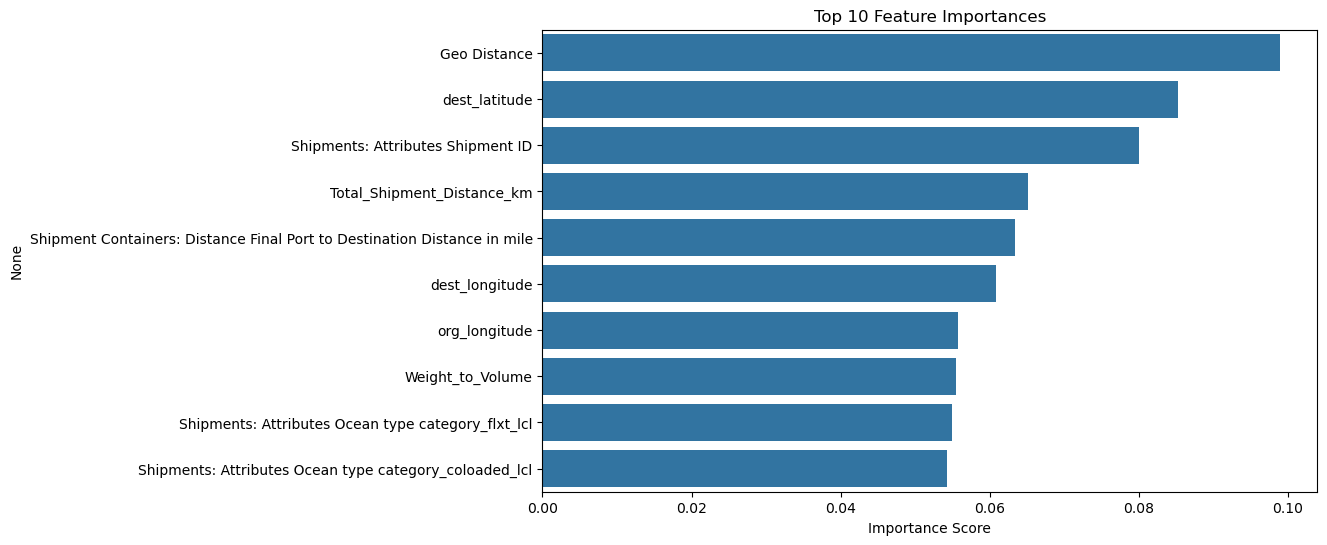

In [14]:

feature_importance = pd.Series(rfg_model.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


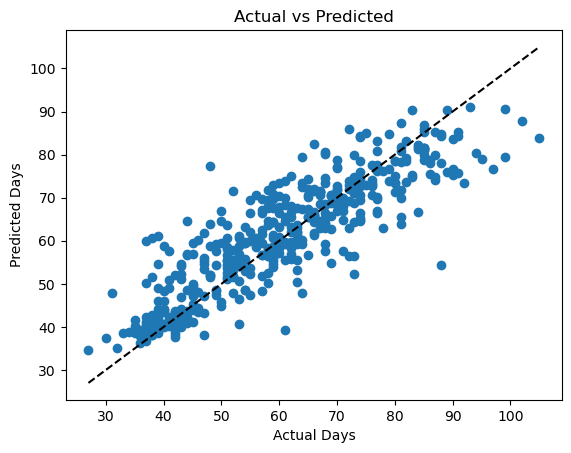

In [15]:
errors = y_test - predictions
plt.scatter(y_test, predictions)
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()


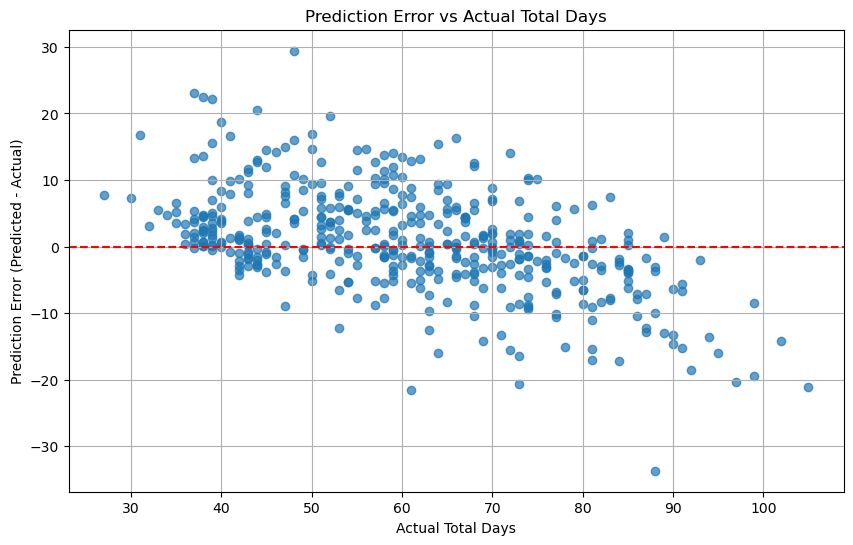

In [16]:

# Calculate residuals (prediction errors)
residuals = predictions - y_test

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Line at y=0 for reference
plt.xlabel("Actual Total Days")
plt.ylabel("Prediction Error (Predicted - Actual)")
plt.title("Prediction Error vs Actual Total Days")
plt.grid(True)
plt.show()
